In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras import mixed_precision

import plotly.graph_objects as go
from datetime import datetime, timedelta

# --- Parameter ---
predict_stock = "#PLTR"  # Neue Aktie für Vorhersage
folderPath_His =  "/mnt/Trainingdata/ml_data/yh_his/D1/"
model_name = "generic_multi_stock_lstm1.keras"
train_stocks = ["#PLTR", "#TSLA", "#PYPL", "#AAPL", "#AMZN","#NVDA"]  # Trainingsaktien
# --- END Parameter ---

# --- GPU-Konfiguration ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU aktiviert: {gpus}")
else:
    print("⚠️ Keine GPU gefunden, CPU wird verwendet.")

# GPU-Optimierungen aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("✅ Memory Growth aktiviert")

mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision aktiviert")

tf.config.optimizer.set_jit(True)
print("✅ XLA aktiviert")

# Benchmark-Test
print("\n🚀 Starte GPU-Benchmark...")
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    start = time.time()
    c = tf.matmul(a, b)
    # Synchronisation erfolgt automatisch, wenn wir das Ergebnis auswerten
    _ = c.numpy()  # zwingt TensorFlow, die Berechnung abzuschließen
    print("✅ Dauer für 10k x 10k Matrix-Multiplikation:", round(time.time() - start, 2), "Sekunden")


sequence_length = 30
forecast_horizon = 30

# --- Hilfsfunktion zum Laden und Vorbereiten der Daten ---
def load_and_prepare_data(stock):
    file_path = os.path.join(folderPath_His, f"{stock}.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Datei nicht gefunden: {file_path}")
    df = pd.read_csv(file_path)
    if "close" not in df.columns:
        raise ValueError(f"❌ Spalte 'close' fehlt in {file_path}")
    df = df.dropna(subset=["close"])
    normalized = (df["close"] - df["close"].mean()) / df["close"].std()
    X, y = [], []
    for i in range(len(normalized) - sequence_length - forecast_horizon):
        X.append(normalized.values[i:i+sequence_length])
        y.append(normalized.values[i+sequence_length:i+sequence_length+forecast_horizon])
    return np.array(X).reshape(-1, sequence_length, 1), np.array(y), df


#model.save("generic_multi_stock_lstm.h5")
#print("✅ Modell gespeichert: generic_multi_stock_lstm.h5")



✅ GPU aktiviert: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Memory Growth aktiviert
✅ Mixed Precision aktiviert
✅ XLA aktiviert

🚀 Starte GPU-Benchmark...
✅ Dauer für 10k x 10k Matrix-Multiplikation: 0.63 Sekunden


In [ ]:


from keras.models import load_model

# Modell laden
model1 = load_model(model_name)

# Überprüfen
model1.summary()

# --- Vorhersage für MSFT ---
X_msft, _, df_msft = load_and_prepare_data(predict_stock)
last_sequence = X_msft[-1].reshape(1, sequence_length, 1)
pred = model1.predict(last_sequence)[0]
pred_denorm = pred * df_msft["close"].std() + df_msft["close"].mean()
# --- HIS 
df = pd.read_csv(os.path.join(folderPath_His, f"{predict_stock}.csv"))
df_his = df.copy()
df.index = pd.to_datetime(df.index)
last_date = df.index[-1]
#future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_pred_days, freq='B')
#df_fc = ['date','fc']

#plt.figure(figsize=(40, 22))
#plt.figure(figsize=(14, 10))

# --- Plot ---
future_dates = [datetime.today() + timedelta(days=i) for i in range(forecast_horizon)]



import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
plt.plot(df_his['date'], df_his['close'], label='IS-HIS close', color='magenta')

plt.plot(future_dates, pred_denorm, label="Genric Forecast (next 100 days)", linestyle='--')
plt.xlabel("date")
plt.ylabel(   " Price")
plt.title("SVR Prediction for "+ predict_stock)
plt.legend()
plt.grid(True)
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,992 (441.39 KB)

 Trainable params: 37,662 (147.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,330 (294.27 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


NameError: name 'df' is not defined

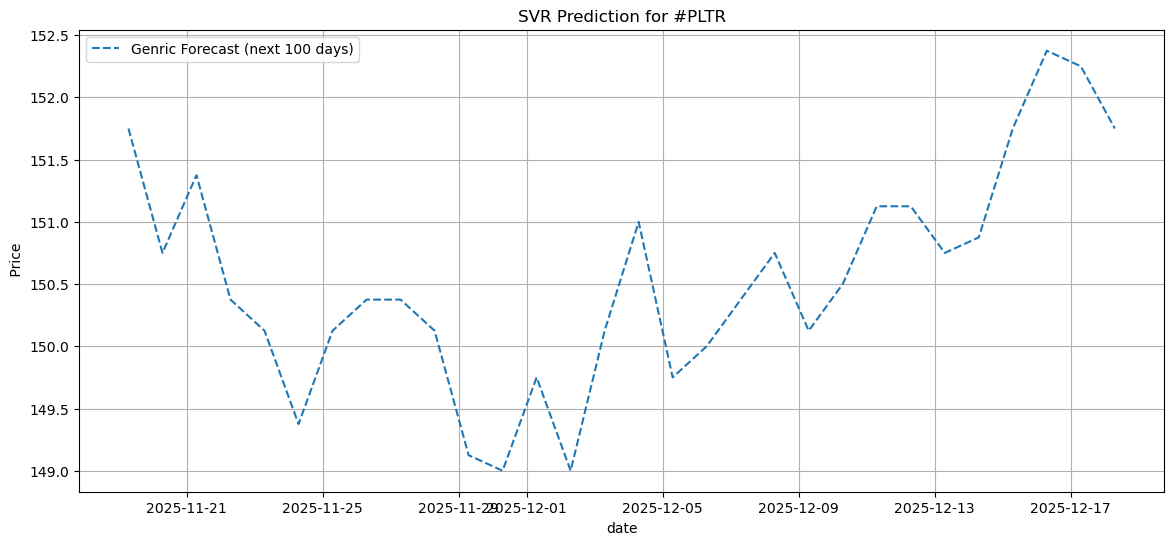

In [ ]:
# --- HIS 
df = pd.read_csv(os.path.join(folderPath_His, f"{predict_stock}.csv"))
df_his = df.copy()
df.index = pd.to_datetime(df.index)
df = df.set_index('date')
last_date = df.index[-1]
#future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_pred_days, freq='B')
#df_fc = ['date','fc']

#plt.figure(figsize=(40, 22))
#plt.figure(figsize=(14, 10))

# --- Plot ---
future_dates = [datetime.today() + timedelta(days=i) for i in range(forecast_horizon)]



import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
#plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
#plt.plot(df['date'], df['close'], label='IS-HIS close', color='magenta')

plt.plot(future_dates, pred_denorm, label="Genric Forecast (next 100 days)", linestyle='--')
plt.xlabel("date")
plt.ylabel(   " Price")
plt.title("SVR Prediction for "+ predict_stock)
plt.legend()
plt.grid(True)
plt.show()